In [1]:
# Cross-dataset evaluation (OneForAll / frozen-head)
# - NO training: loads saved checkpoints from an existing run directory
# - Evaluates activations from a different dataset on the saved prober (shared head + encoder)

from __future__ import annotations

import json
import os
from pathlib import Path
import gc
import random
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional

import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
 )

# ---------------------------
# Repro / device
# ---------------------------
SEED = 42
def set_seed(seed: int = SEED) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

# ---------------------------
# Project paths
# ---------------------------
# NOTE: this notebook lives in notebooks/nonLinearApproach/approach3OneForAll/
PROJECT_ROOT = Path(os.getcwd()).resolve()
while PROJECT_ROOT.name != "HallucinationDetection" and PROJECT_ROOT.parent != PROJECT_ROOT:
    PROJECT_ROOT = PROJECT_ROOT.parent
if PROJECT_ROOT.name != "HallucinationDetection":
    raise RuntimeError("Could not locate project root 'HallucinationDetection' from cwd")

CACHE_DIR = PROJECT_ROOT / "activation_cache"
ONEFORALL_DIR = PROJECT_ROOT / "notebooks" / "nonLinearApproach" / "approach3OneForAll"
print("PROJECT_ROOT:", PROJECT_ROOT)
print("CACHE_DIR:", CACHE_DIR)
print("ONEFORALL_DIR:", ONEFORALL_DIR)

Using device: cuda
PROJECT_ROOT: C:\Users\fonta\Desktop\HallucinationDetection
CACHE_DIR: C:\Users\fonta\Desktop\HallucinationDetection\activation_cache
ONEFORALL_DIR: C:\Users\fonta\Desktop\HallucinationDetection\notebooks\nonLinearApproach\approach3OneForAll


# Cross-dataset evaluation (OneForAll)
Questo notebook fa **transfer cross-dataset** senza ri-addestrare nulla:
- Scegli una run OneForAll già eseguita (dove ci sono `models_frozen_head/.../*.pt`).
- Carica **Teacher encoder + shared head** e **Student adapter encoder** da quella run.
- Usa lo **scaler stimato dal dataset di training** (ricostruito dalle attivazioni del dataset di training).
- Valuta su un altro dataset: attivazioni $\to$ (encoder) $\to$ head (prober).

Nota: OneForAll qui è la variante **Frozen Head** (encoder+head per teacher, encoder adapter per student, head condiviso congelato).

In [3]:
# ---------------------------
# Discovery: where checkpoints are saved
# ---------------------------
def find_oneforall_runs(base_dir: Path) -> List[Path]:
    """Find run folders that contain models_frozen_head."""
    runs = []
    if not base_dir.exists():
        return runs
    for p in base_dir.iterdir():
        if not p.is_dir():
            continue
        if (p / "models_frozen_head").exists():
            runs.append(p)
    return sorted(runs)

runs = find_oneforall_runs(ONEFORALL_DIR)
print("Found OneForAll runs:")
for r in runs:
    print(" -", r.relative_to(PROJECT_ROOT))

Found OneForAll runs:
 - notebooks/nonLinearApproach/approach3OneForAll/LLama_Gemma_BBC
 - notebooks/nonLinearApproach/approach3OneForAll/LLama_Gemma_BBF
 - notebooks/nonLinearApproach/approach3OneForAll/LLama_Gemma_HE


In [4]:
# ---------------------------
# Activation loading (same as OneForAll run)
# ---------------------------
def detect_structure_type(model_name: str, dataset_name: str, layer_type: str = "attn") -> str:
    base_path = CACHE_DIR / model_name / dataset_name / f"activation_{layer_type}"
    if (base_path / "hallucinated").is_dir():
        return "new"
    return "old"

def stats_from_new_structure(model_name: str, dataset_name: str, layer_type: str = "attn") -> Dict:
    base_path = CACHE_DIR / model_name / dataset_name / f"activation_{layer_type}"
    hallucinated_path = base_path / "hallucinated"
    not_hallucinated_path = base_path / "not_hallucinated"
    hall_ids_path = hallucinated_path / "layer0_instance_ids.json"
    not_hall_ids_path = not_hallucinated_path / "layer0_instance_ids.json"
    with open(hall_ids_path, "r") as f:
        hallucinated_ids = json.load(f)
    with open(not_hall_ids_path, "r") as f:
        not_hallucinated_ids = json.load(f)
    total = len(hallucinated_ids) + len(not_hallucinated_ids)
    return {
        "total": total,
        "hallucinations": len(hallucinated_ids),
        "not_hallucinations": len(not_hallucinated_ids),
        "hallucinated_ids": hallucinated_ids,
        "not_hallucinated_ids": not_hallucinated_ids,
        "hallucinated_items": hallucinated_ids,  # compat
        "model_name": model_name,
    }

def stats_old_structure(model_name: str, dataset_name: str) -> Dict:
    file_path = CACHE_DIR / model_name / dataset_name / "generations" / "hallucination_labels.json"
    with open(file_path, "r") as f:
        data = json.load(f)
    total = len(data)
    hallucinated_items = [item["instance_id"] for item in data if item["is_hallucination"]]
    return {
        "total": total,
        "hallucinations": len(hallucinated_items),
        "hallucinated_items": hallucinated_items,
        "model_name": model_name,
    }

def get_stats(model_name: str, dataset_name: str, layer_type: str = "attn") -> Dict:
    st = detect_structure_type(model_name, dataset_name, layer_type=layer_type)
    if st == "new":
        return stats_from_new_structure(model_name, dataset_name, layer_type=layer_type)
    return stats_old_structure(model_name, dataset_name)

def get_balanced_indices(y: np.ndarray, seed: int = SEED) -> np.ndarray:
    rng = np.random.RandomState(seed)
    unique, counts = np.unique(y, return_counts=True)
    min_count = counts.min()
    selected = []
    for cls in unique:
        cls_idx = np.where(y == cls)[0]
        if len(cls_idx) > min_count:
            sampled = rng.choice(cls_idx, size=min_count, replace=False)
            selected.extend(sampled)
        else:
            selected.extend(cls_idx)
    return np.sort(np.array(selected))

def get_undersampled_indices_per_model(model_stats: Dict, seed: int = SEED) -> Tuple[np.ndarray, np.ndarray]:
    total = model_stats["total"]
    hall_set = set(model_stats["hallucinated_items"])
    y = np.array([1 if i in hall_set else 0 for i in range(total)], dtype=np.int64)
    balanced_idx = get_balanced_indices(y, seed=seed)
    balanced_labels = y[balanced_idx]
    return balanced_idx, balanced_labels

def load_features_for_indices(
    model_name: str,
    dataset_name: str,
    layer_indices: List[int],
    layer_type: str,
    select_indices: np.ndarray,
) -> np.ndarray:
    """Load concatenated activations for given global instance indices (already ordered)."""
    structure_type = detect_structure_type(model_name, dataset_name, layer_type=layer_type)
    all_features = []
    for layer_idx in layer_indices:
        base_path = CACHE_DIR / model_name / dataset_name / f"activation_{layer_type}"
        if structure_type == "new":
            hall_path = base_path / "hallucinated" / f"layer{layer_idx}_activations.pt"
            not_hall_path = base_path / "not_hallucinated" / f"layer{layer_idx}_activations.pt"
            hall_ids_path = base_path / "hallucinated" / f"layer{layer_idx}_instance_ids.json"
            not_hall_ids_path = base_path / "not_hallucinated" / f"layer{layer_idx}_instance_ids.json"
            if not hall_path.exists() or not not_hall_path.exists():
                raise FileNotFoundError(f"Missing layer {layer_idx} for {model_name}/{dataset_name}/{layer_type}")
            acts_hall = torch.load(hall_path, map_location="cpu")
            acts_not_hall = torch.load(not_hall_path, map_location="cpu")
            with open(hall_ids_path, "r") as f:
                hall_ids = json.load(f)
            with open(not_hall_ids_path, "r") as f:
                not_hall_ids = json.load(f)
            X_hall = acts_hall.float().numpy() if isinstance(acts_hall, torch.Tensor) else acts_hall.astype(np.float32)
            X_not = acts_not_hall.float().numpy() if isinstance(acts_not_hall, torch.Tensor) else acts_not_hall.astype(np.float32)
            if X_hall.ndim > 2:
                X_hall = X_hall.reshape(X_hall.shape[0], -1)
            if X_not.ndim > 2:
                X_not = X_not.reshape(X_not.shape[0], -1)
            total_samples = len(hall_ids) + len(not_hall_ids)
            feature_dim = X_hall.shape[1]
            X_layer = np.zeros((total_samples, feature_dim), dtype=np.float32)
            for i, inst_id in enumerate(hall_ids):
                X_layer[inst_id] = X_hall[i]
            for i, inst_id in enumerate(not_hall_ids):
                X_layer[inst_id] = X_not[i]
            del acts_hall, acts_not_hall, X_hall, X_not
        else:
            file_path = base_path / f"layer{layer_idx}_activations.pt"
            if not file_path.exists():
                raise FileNotFoundError(f"Missing layer {layer_idx} for {model_name}/{dataset_name}/{layer_type}")
            acts = torch.load(file_path, map_location="cpu")
            X_layer = acts.float().numpy() if isinstance(acts, torch.Tensor) else acts.astype(np.float32)
            if X_layer.ndim > 2:
                X_layer = X_layer.reshape(X_layer.shape[0], -1)
            del acts
        X_layer = X_layer[select_indices]
        all_features.append(X_layer)
        gc.collect()
    X = np.concatenate(all_features, axis=1).astype(np.float32)
    return X

In [5]:
# ---------------------------
# OneForAll models (frozen-head)
# ---------------------------
class Encoder(nn.Module):
    def __init__(self, input_dim: int, latent_dim: int, hidden_dim: int = 1024, dropout: float = 0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LayerNorm(hidden_dim // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, latent_dim),
            nn.LayerNorm(latent_dim),
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

class ClassificationHead(nn.Module):
    def __init__(self, latent_dim: int, hidden_dim: int = 128, dropout: float = 0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1),
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x).squeeze(-1)
    @torch.no_grad()
    def predict(self, x: torch.Tensor) -> torch.Tensor:
        logits = self.forward(x)
        return (torch.sigmoid(logits) > 0.5).long()

def load_teacher_encoder(run_dir: Path, layer_type: str, teacher_model: str) -> Encoder:
    ckpt_path = run_dir / "models_frozen_head" / layer_type / f"frozen_head_encoder_{teacher_model}.pt"
    ckpt = torch.load(ckpt_path, map_location="cpu")
    cfg = ckpt["encoder_config"]
    enc = Encoder(
        input_dim=int(ckpt["input_dim"]),
        latent_dim=int(cfg["latent_dim"]),
        hidden_dim=int(cfg["hidden_dim"]),
        dropout=float(cfg["dropout"]),
    )
    enc.load_state_dict(ckpt["model_state_dict"])
    enc.to(DEVICE).eval()
    return enc

def load_student_encoder(run_dir: Path, layer_type: str, student_model: str) -> Encoder:
    ckpt_path = run_dir / "models_frozen_head" / layer_type / f"frozen_head_encoder_{student_model}_adapter.pt"
    ckpt = torch.load(ckpt_path, map_location="cpu")
    cfg = ckpt["encoder_config"]
    enc = Encoder(
        input_dim=int(ckpt["input_dim"]),
        latent_dim=int(cfg["latent_dim"]),
        hidden_dim=int(cfg["hidden_dim"]),
        dropout=float(cfg["dropout"]),
    )
    enc.load_state_dict(ckpt["model_state_dict"])
    enc.to(DEVICE).eval()
    return enc

def load_shared_head(run_dir: Path, layer_type: str, teacher_model: str) -> ClassificationHead:
    ckpt_path = run_dir / "models_frozen_head" / layer_type / f"frozen_head_shared_head_{teacher_model}.pt"
    ckpt = torch.load(ckpt_path, map_location="cpu")
    cfg = ckpt["head_config"]
    head = ClassificationHead(
        latent_dim=int(ckpt["latent_dim"]),
        hidden_dim=int(cfg["hidden_dim"]),
        dropout=float(cfg["dropout"]),
    )
    head.load_state_dict(ckpt["model_state_dict"])
    head.to(DEVICE).eval()
    return head

In [6]:
# ---------------------------
# Eval helpers
# ---------------------------
@torch.no_grad()
def predict_with_encoder_head(encoder: Encoder, head: ClassificationHead, X: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    X_t = torch.from_numpy(X).float().to(DEVICE)
    z = encoder(X_t)
    logits = head(z)
    probs = torch.sigmoid(logits).detach().cpu().numpy()
    preds = (probs > 0.5).astype(np.int64)
    return preds, probs

def compute_metrics(y_true: np.ndarray, y_pred: np.ndarray, y_prob: np.ndarray) -> Dict:
    # AUROC requires both classes present; if not, return NaN
    try:
        auroc = float(roc_auc_score(y_true, y_prob))
    except Exception:
        auroc = float("nan")
    cm = confusion_matrix(y_true, y_pred).tolist()
    return {
        "accuracy": float(accuracy_score(y_true, y_pred)),
        "precision": float(precision_score(y_true, y_pred, zero_division=0)),
        "recall": float(recall_score(y_true, y_pred, zero_division=0)),
        "f1": float(f1_score(y_true, y_pred, zero_division=0)),
        "auroc": auroc,
        "confusion_matrix": cm,
    }

def fit_scaler_from_training_dataset(
    model_name: str,
    dataset_train: str,
    layer_indices: List[int],
    layer_type: str,
    seed: int = SEED,
    train_fraction: float = 0.7,
    scaler_fit_on: str = "train",  # 'train' or 'all'
 ) -> StandardScaler:
    """Rebuild the StandardScaler used in the original run (approx.).
    - We undersample deterministically per model (seed)
    - We split deterministically (seed)
    - Fit scaler either on train only (recommended) or all balanced samples (fallback)
    """
    stats = get_stats(model_name, dataset_train, layer_type=layer_type)
    balanced_idx, _ = get_undersampled_indices_per_model(stats, seed=seed)
    X_bal = load_features_for_indices(model_name, dataset_train, layer_indices, layer_type, balanced_idx)
    rng = np.random.RandomState(seed)
    perm = rng.permutation(len(balanced_idx))
    split = int(train_fraction * len(perm))
    train_local = perm[:split]
    if scaler_fit_on == "all":
        X_fit = X_bal
    else:
        X_fit = X_bal[train_local]
    scaler = StandardScaler()
    scaler.fit(X_fit)
    return scaler

def load_balanced_eval_set(
    model_name: str,
    dataset_name: str,
    layer_indices: List[int],
    layer_type: str,
    seed: int = SEED,
 ) -> Tuple[np.ndarray, np.ndarray]:
    stats = get_stats(model_name, dataset_name, layer_type=layer_type)
    balanced_idx, balanced_y = get_undersampled_indices_per_model(stats, seed=seed)
    X = load_features_for_indices(model_name, dataset_name, layer_indices, layer_type, balanced_idx)
    return X, balanced_y.astype(np.int64)

In [7]:
# ---------------------------
# Cross-dataset evaluation core
# ---------------------------
def eval_cross_dataset_oneforall(
    encoder_run_dir: Path,
    head_run_dir: Path,
    dataset_train: str,
    dataset_activation: str,
    dataset_head: str,
    teacher_model: str,
    student_model: str,
    layer_type: str,
    layer_config: Dict[str, Dict[str, List[int]]],
    seed_teacher_scaler: int = SEED,
    seed_student_scaler: int = SEED + 1,
    seed_teacher_eval: int = SEED,
    seed_student_eval: int = SEED,
    scaler_fit_on: str = "train",
 ) -> Dict:
    """
    Loads encoder from encoder_run_dir (trained on dataset_train).
    Loads head from head_run_dir (trained on dataset_head).
    Evaluates on dataset_activation.
    """
    # 1) Load checkpoints
    teacher_enc = load_teacher_encoder(encoder_run_dir, layer_type, teacher_model)
    student_enc = load_student_encoder(encoder_run_dir, layer_type, student_model)
    
    # Load shared head from the HEAD run
    shared_head = load_shared_head(head_run_dir, layer_type, teacher_model)

    # 2) Rebuild scalers from TRAIN dataset (to match encoder training preprocessing)
    teacher_layers = layer_config[teacher_model][layer_type]
    student_layers = layer_config[student_model][layer_type]
    scaler_teacher = fit_scaler_from_training_dataset(
        model_name=teacher_model,
        dataset_train=dataset_train,
        layer_indices=teacher_layers,
        layer_type=layer_type,
        seed=seed_teacher_scaler,
        scaler_fit_on=scaler_fit_on,
    )
    scaler_student = fit_scaler_from_training_dataset(
        model_name=student_model,
        dataset_train=dataset_train,
        layer_indices=student_layers,
        layer_type=layer_type,
        seed=seed_student_scaler,
        scaler_fit_on=scaler_fit_on,
    )

    # 3) Load ACTIVATION dataset (balanced)
    X_t, y_t = load_balanced_eval_set(teacher_model, dataset_activation, teacher_layers, layer_type, seed=seed_teacher_eval)
    X_s, y_s = load_balanced_eval_set(student_model, dataset_activation, student_layers, layer_type, seed=seed_student_eval)

    # 4) Apply TRAIN scalers to ACTIVATION features
    X_t = scaler_teacher.transform(X_t).astype(np.float32)
    X_s = scaler_student.transform(X_s).astype(np.float32)

    # 5) Predict + metrics
    pred_t, prob_t = predict_with_encoder_head(teacher_enc, shared_head, X_t)
    pred_s, prob_s = predict_with_encoder_head(student_enc, shared_head, X_s)

    out = {
        "encoder_run_dir": str(encoder_run_dir.relative_to(PROJECT_ROOT)),
        "head_run_dir": str(head_run_dir.relative_to(PROJECT_ROOT)),
        "dataset_train": dataset_train,
        "dataset_activation": dataset_activation,
        "dataset_head": dataset_head,
        "layer_type": layer_type,
        "teacher_model": teacher_model,
        "student_model": student_model,
        "scaler_fit_on": scaler_fit_on,
        "eval": {
            "teacher_on_eval": compute_metrics(y_t, pred_t, prob_t),
            "student_adapter_on_eval": compute_metrics(y_s, pred_s, prob_s),
        },
        "n_samples": {
            "teacher_eval": int(len(y_t)),
            "student_eval": int(len(y_s)),
        }
    }
    return out

In [19]:
# ---------------------------
# Configure YOUR experiments here
# ---------------------------
# 1) Run that produced the encoder, adapter and scaler for DATASET_TRAIN
ENCODER_RUN_DIR = ONEFORALL_DIR / "LLama_Gemma_BBF"  # <- change if needed
# 2) Separate run whose shared head you want to reuse (typically trained on DATASET_HEAD)
HEAD_RUN_DIR = ONEFORALL_DIR / "LLama_Gemma_BBC"  # <- change if needed

# 3) Dataset used to train the encoder/scaler run (used only to rebuild scalers)
DATASET_TRAIN = "belief_bank_facts"  # <- change if needed
# 4) Dataset whose activations you feed through that encoder
DATASET_ACTIVATION = "belief_bank_facts"  # <- change if needed
# 5) Dataset whose run produced the shared head you reuse for scoring
DATASET_HEAD = "belief_bank_constraints"  # <- change if needed

# 6) Scenario (teacher -> student) used in the encoder run; we load the corresponding checkpoints
TEACHER_MODEL = "gemma-2-9b-it"
STUDENT_MODEL = "Llama-3.1-8B-Instruct"
#TEACHER_MODEL = "Llama-3.1-8B-Instruct"
#STUDENT_MODEL = "gemma-2-9b-it"

# 7) Layer configuration must match the run settings (same as in app3.py)
LAYER_CONFIG = {
    "gemma-2-9b-it": {
        "attn": [21, 24, 27],
        "mlp": [22, 25, 27],
        "hidden": [23,26, 34],
    },
    "Llama-3.1-8B-Instruct": {
        "attn": [8, 13, 14],
        "mlp": [14, 15, 21],
        "hidden": [14, 15, 16],
    },
}

# Sanity
assert ENCODER_RUN_DIR.exists(), f"Missing ENCODER_RUN_DIR: {ENCODER_RUN_DIR}"
assert (ENCODER_RUN_DIR / "models_frozen_head").exists(), "ENCODER_RUN_DIR must contain models_frozen_head/"
assert HEAD_RUN_DIR.exists(), f"Missing HEAD_RUN_DIR: {HEAD_RUN_DIR}"
assert (HEAD_RUN_DIR / "models_frozen_head").exists(), "HEAD_RUN_DIR must contain models_frozen_head/"
print("Encoder run:", ENCODER_RUN_DIR.relative_to(PROJECT_ROOT))
print("Head run:", HEAD_RUN_DIR.relative_to(PROJECT_ROOT))
print("Train dataset:", DATASET_TRAIN)
print("Activation dataset:", DATASET_ACTIVATION)
print("Head dataset:", DATASET_HEAD)
print("Teacher:", TEACHER_MODEL, "Student:", STUDENT_MODEL)

Encoder run: notebooks/nonLinearApproach/approach3OneForAll/LLama_Gemma_BBF
Head run: notebooks/nonLinearApproach/approach3OneForAll/LLama_Gemma_BBC
Train dataset: belief_bank_facts
Activation dataset: belief_bank_facts
Head dataset: belief_bank_constraints
Teacher: gemma-2-9b-it Student: Llama-3.1-8B-Instruct


In [20]:
# ---------------------------
# Run cross-dataset evaluation (NO training)
# ---------------------------
results = []
for layer_type in ["attn", "mlp", "hidden"]:
    print("\n" + "=" * 80)
    print("LAYER:", layer_type)
    print("=" * 80)
    r = eval_cross_dataset_oneforall(
        encoder_run_dir=ENCODER_RUN_DIR,
        head_run_dir=HEAD_RUN_DIR,
        dataset_train=DATASET_TRAIN,
        dataset_activation=DATASET_ACTIVATION,
        dataset_head=DATASET_HEAD,
        teacher_model=TEACHER_MODEL,
        student_model=STUDENT_MODEL,
        layer_type=layer_type,
        layer_config=LAYER_CONFIG,
        scaler_fit_on="train",
    )
    results.append(r)
    print("Teacher on eval:", r["eval"]["teacher_on_eval"])
    print("Student adapter on eval:", r["eval"]["student_adapter_on_eval"])

# Save JSON next to the run folder (separate from original training results)
out_dir = ENCODER_RUN_DIR / "results_metrics"
out_dir.mkdir(parents=True, exist_ok=True)
out_path = out_dir / f"cross_dataset_eval__activation-{DATASET_ACTIVATION}__head-{DATASET_HEAD}__train-{DATASET_TRAIN}__teacher-{TEACHER_MODEL}__student-{STUDENT_MODEL}.json"
with open(out_path, "w") as f:
    json.dump(results, f, indent=2)
print("\nSaved:", out_path.relative_to(PROJECT_ROOT))


LAYER: attn
Teacher on eval: {'accuracy': 0.986284289276808, 'precision': 0.9911838790931989, 'recall': 0.9812967581047382, 'f1': 0.9862155388471178, 'auroc': 0.9967249892724548, 'confusion_matrix': [[795, 7], [15, 787]]}
Student adapter on eval: {'accuracy': 0.9941634241245136, 'precision': 0.994988864142539, 'recall': 0.9933296275708727, 'f1': 0.9941585535465924, 'auroc': 0.9973266600770424, 'confusion_matrix': [[1790, 9], [12, 1787]]}

LAYER: mlp
Teacher on eval: {'accuracy': 0.9825436408977556, 'precision': 0.9825436408977556, 'recall': 0.9825436408977556, 'f1': 0.9825436408977556, 'auroc': 0.99172113357504, 'confusion_matrix': [[788, 14], [14, 788]]}
Student adapter on eval: {'accuracy': 0.9936075597554197, 'precision': 0.9922394678492239, 'recall': 0.9949972206781545, 'f1': 0.993616430752151, 'auroc': 0.9979892788316403, 'confusion_matrix': [[1785, 14], [9, 1790]]}

LAYER: hidden
Teacher on eval: {'accuracy': 0.9719451371571073, 'precision': 0.9821656050955414, 'recall': 0.96134

Visualizing performance with graphs

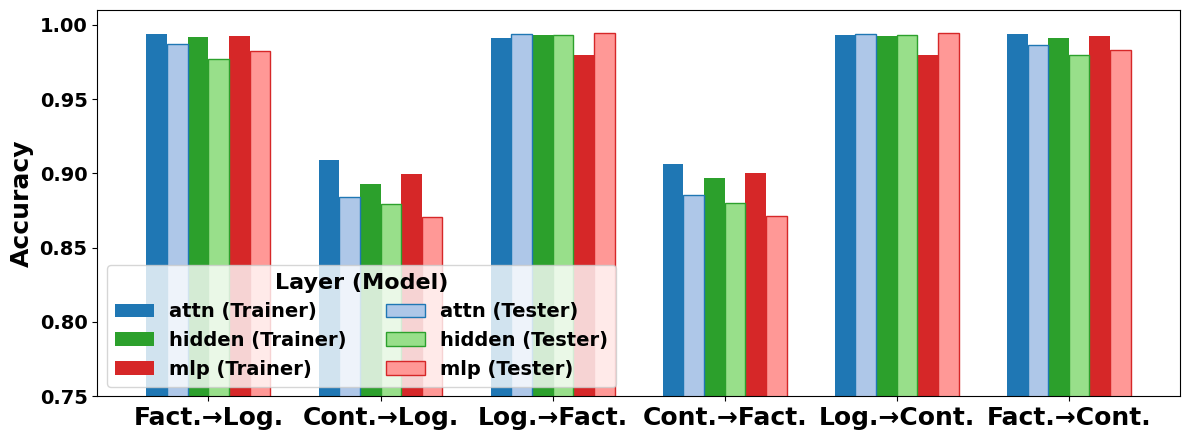


Teacher (Llama-3.1-8B-Instruct) Accuracy values (Encoder→Head, rows=domains, cols=layers):
Domain           attn   hidden      mlp
Fact.→Log.     0.9942   0.9917   0.9922
Cont.→Log.     0.9092   0.8928   0.8999
Log.→Fact.     0.9913   0.9932   0.9797
Cont.→Fact.    0.9066   0.8968   0.9006
Log.→Cont.     0.9928   0.9928   0.9798
Fact.→Cont.    0.9942   0.9914   0.9925

Student (gemma-2-9b-it) Accuracy values (Encoder→Head, rows=domains, cols=layers):
Domain           attn   hidden      mlp
Fact.→Log.     0.9869   0.9769   0.9825
Cont.→Log.     0.8841   0.8795   0.8706
Log.→Fact.     0.9939   0.9934   0.9943
Cont.→Fact.    0.8852   0.8800   0.8712
Log.→Cont.     0.9939   0.9933   0.9944
Fact.→Cont.    0.9863   0.9794   0.9832


In [23]:
import matplotlib.pyplot as plt
import numpy as np
import json
from pathlib import Path

# Models - change these to switch teacher/student
teacher_model = "Llama-3.1-8B-Instruct"
student_model = "gemma-2-9b-it"

# Short names for display
model_short = {
    "gemma-2-9b-it": "Gemma",
    "Llama-3.1-8B-Instruct": "Llama",
}
teacher_short = model_short.get(teacher_model, teacher_model)
student_short = model_short.get(student_model, student_model)

# Domain configurations: (encoder_run_folder, head_run_folder, display_name)
# Notation: Encoder_trained_on → Head_trained_on
# BBC = belief_bank_constraints, BBF = belief_bank_facts, HE = halu_eval
domain_configs = [
    ("LLama_Gemma_BBF", "LLama_Gemma_BBC", "Fact.→Log."),  # encoder=BBF, head=BBC
    ("LLama_Gemma_HE", "LLama_Gemma_BBC", "Cont.→Log."),    # encoder=HE, head=BBC
    ("LLama_Gemma_BBC", "LLama_Gemma_BBF", "Log.→Fact."),  # encoder=BBC, head=BBF
    ("LLama_Gemma_HE", "LLama_Gemma_BBF", "Cont.→Fact."),    # encoder=HE, head=BBF
    ("LLama_Gemma_BBC", "LLama_Gemma_HE", "Log.→Cont."),    # encoder=BBC, head=HE
    ("LLama_Gemma_BBF", "LLama_Gemma_HE", "Fact.→Cont."),    # encoder=BBF, head=HE
]

# Map folder names to dataset names
folder_to_dataset = {
    "LLama_Gemma_BBC": "belief_bank_constraints",
    "LLama_Gemma_BBF": "belief_bank_facts",
    "LLama_Gemma_HE": "halu_eval",
}

layers = ["attn", "hidden", "mlp"]

# Collect AUROC values: rows = domains, cols = layers
# Separate arrays for teacher and student
data_trainer = np.zeros((len(domain_configs), len(layers)))
data_tester = np.zeros((len(domain_configs), len(layers)))

for i, (enc_folder, head_folder, domain_name) in enumerate(domain_configs):
    enc_dataset = folder_to_dataset[enc_folder]
    head_dataset = folder_to_dataset[head_folder]
    
    # Build file path: file is stored in the encoder_run folder
    results_dir = ONEFORALL_DIR / enc_folder / "results_metrics"
    filename = f"cross_dataset_eval__activation-{enc_dataset}__head-{head_dataset}__train-{enc_dataset}__teacher-{teacher_model}__student-{student_model}.json"
    filepath = results_dir / filename
    
    if filepath.exists():
        with open(filepath, "r") as f:
            results = json.load(f)
        # Extract AUROC for each layer type (teacher and student)
        for result in results:
            layer_type = result["layer_type"]
            accuracy_trainer = result["eval"]["teacher_on_eval"]["accuracy"]
            accuracy_tester = result["eval"]["student_adapter_on_eval"]["accuracy"]
            if layer_type in layers:
                j = layers.index(layer_type)
                data_trainer[i, j] = accuracy_trainer
                data_tester[i, j] = accuracy_tester
    else:
        print(f"Missing: {filepath}")

domains = [cfg[2] for cfg in domain_configs]
x = np.arange(len(domains))
width = 0.12  # Reduced width to fit 6 bars (3 layers x 2 models)

fig, ax = plt.subplots(figsize=(12, 4.5))

colors_teacher = ['#1f77b4', '#2ca02c', '#d62728']  # Blue, Green, Red
colors_student = ['#aec7e8', '#98df8a', '#ff9896']  # Lighter versions

# Plot teacher bars (solid)
for i, layer in enumerate(layers):
    offset = (i - 1) * width * 2 - width/2
    ax.bar(x + offset, data_trainer[:, i], width, label=f'{layer} (Trainer)', color=colors_teacher[i])

# Plot student bars (lighter, adjacent to teacher)
for i, layer in enumerate(layers):
    offset = (i - 1) * width * 2 + width/2
    ax.bar(x + offset, data_tester[:, i], width, label=f'{layer} (Tester)', color=colors_student[i], edgecolor=colors_teacher[i], linewidth=1)

ax.set_xticks(x)
ax.set_xticklabels(domains, rotation=0, ha="center", fontsize=18, fontweight='bold')
ax.set_ylabel("Accuracy", fontsize=18, fontweight='bold')
ax.tick_params(axis='y', labelsize=14)
# Make y-axis tick labels bold
for lbl in ax.get_yticklabels():
    lbl.set_fontweight('bold')
# Dynamically set y-axis limits based on data
all_values = np.concatenate([data_trainer.flatten(), data_tester.flatten()])
all_values = all_values[all_values > 0]  # Exclude zeros (missing data)
y_min = 0.75  # Round down to nearest 0.05
ax.set_ylim(y_min, 1.01)
ax.legend(title="Layer (Model)", fontsize=14, ncol=2, loc='lower left', 
          prop={'weight': 'bold', 'size': 14}, title_fontproperties={'weight': 'bold', 'size': 16})
plt.tight_layout()
plt.savefig(f"fig_cross_domain_{teacher_model}_to_{student_model}.pdf")
plt.show()

# Print the data matrix for reference
print(f"\nTeacher ({teacher_model}) Accuracy values (Encoder→Head, rows=domains, cols=layers):")
print(f"{'Domain':<12} " + " ".join(f"{l:>8}" for l in layers))
for i, domain in enumerate(domains):
    print(f"{domain:<12} " + " ".join(f"{data_trainer[i,j]:>8.4f}" for j in range(len(layers))))

print(f"\nStudent ({student_model}) Accuracy values (Encoder→Head, rows=domains, cols=layers):")
print(f"{'Domain':<12} " + " ".join(f"{l:>8}" for l in layers))
for i, domain in enumerate(domains):
    print(f"{domain:<12} " + " ".join(f"{data_tester[i,j]:>8.4f}" for j in range(len(layers))))
